https://www.math.hkust.edu.hk/~maykwok/Web_ppt/KMV/KMV.pdf

FIRMA BARRY CALLEBAUT

![Zrzut ekranu 2024-06-10 135350.png](<attachment:Zrzut ekranu 2024-06-10 135350.png>)
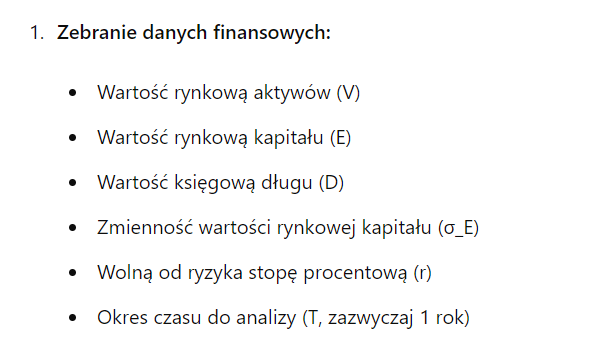

In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

# Pobierz dane dla Barry Callebaut (BYCBF)
ticker = 'BYCBF'
data = yf.Ticker(ticker)

# Pobierz historyczne dane rynkowe
dane_rynkowe = data.history(period="1y")
aktualna_cena = dane_rynkowe['Close'].iloc[-1]
liczba_akcji = data.info['sharesOutstanding']

# Oblicz wartość rynkową kapitału (E)
wartosc_rynkowa_kapitalu = aktualna_cena * liczba_akcji

# Pobierz wartość księgową długu (D)
wartosc_ksiegowa_dlugu = data.info['totalDebt']

# Oblicz dzienną zmienność (σ_E)
dane_rynkowe['Dzienny Zwrot'] = dane_rynkowe['Close'].pct_change()
dzienna_zmiennosc = dane_rynkowe['Dzienny Zwrot'].std()

# Przeskaluj do rocznej zmienności (σ_E)
roczna_zmiennosc = dzienna_zmiennosc * np.sqrt(252)
zmiennosc_kapitalu = roczna_zmiennosc

# Ustal wolną od ryzyka stopę procentową (r)
stopa_wolna_od_ryzyka = 0.0517

# Ustal okres czasu do analizy (T)
okres_analizy = 1

# Funkcja do iteracyjnego oszacowania wartości rynkowej aktywów (V) i ich zmienności (σ_V)
def oszacuj_v_sigma(E, D, sigma_E, r, T):
    def rownania(p):
        V, sigma_V = p
        d1 = (np.log(V/D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
        d2 = d1 - sigma_V * np.sqrt(T)
        eq1 = E - (V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2))
        eq2 = sigma_E - (V * norm.cdf(d1) * sigma_V) / E
        return (eq1, eq2)
    
    V_initial = E + D
    sigma_V_initial = sigma_E * (E / (E + D))
    V, sigma_V = fsolve(rownania, (V_initial, sigma_V_initial))
    return V, sigma_V

# Funkcja do obliczenia prawdopodobieństwa defaultu (PD)
def oblicz_pd(E, D, sigma_E, r, T):
    V, sigma_V = oszacuj_v_sigma(E, D, sigma_E, r, T)
    d1 = (np.log(V/D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    dd = (np.log(V/D) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    PD = norm.cdf(-dd)
    return PD, V, sigma_V

# Obliczanie PD dla Barry Callebaut
PD_bc, V_bc, sigma_V_bc = oblicz_pd(wartosc_rynkowa_kapitalu, wartosc_ksiegowa_dlugu, zmiennosc_kapitalu, stopa_wolna_od_ryzyka, okres_analizy)
ecr = wartosc_rynkowa_kapitalu / wartosc_ksiegowa_dlugu


print(f"Wartość Rynkowa Kapitału (E): {wartosc_rynkowa_kapitalu:.4g} USD")
print(f"Wartość Księgowa Długu (D): {wartosc_ksiegowa_dlugu:.4g} USD")
print(f"Zmienność dzienna: {dzienna_zmiennosc:.4g}")
print(f"Zmienność Wartości Rynkowej Kapitału (σ_E): {zmiennosc_kapitalu:.4g}")
print(f"Wolna od Ryzyka Stopa Procentowa (r): {stopa_wolna_od_ryzyka:.4g}")
print(f"Okres Analizy (T): {okres_analizy:.4g} rok")

Wartość Rynkowa Kapitału (E): 9.311e+09 USD
Wartość Księgowa Długu (D): 3.065e+09 USD
Zmienność dzienna: 0.02399
Zmienność Wartości Rynkowej Kapitału (σ_E): 0.3808
Wolna od Ryzyka Stopa Procentowa (r): 0.0517
Okres Analizy (T): 1 rok


In [39]:
print(f"Prawdopodobieństwo Defaultu (PD): {PD_bc:.4g}")
print(f"Wartość Rynkowa Aktywów (V): {V_bc:.4g}")
print(f"Zmienność Wartości Rynkowej Aktywów (σ_V): {sigma_V_bc:.4g}")
print(f"Wskaźnik Pokrycia Kapitałowego (ECR): {ecr:.4g}")

Prawdopodobieństwo Defaultu (PD): 7.922e-07
Wartość Rynkowa Aktywów (V): 1.222e+10
Zmienność Wartości Rynkowej Aktywów (σ_V): 0.2901
Wskaźnik Pokrycia Kapitałowego (ECR): 3.037


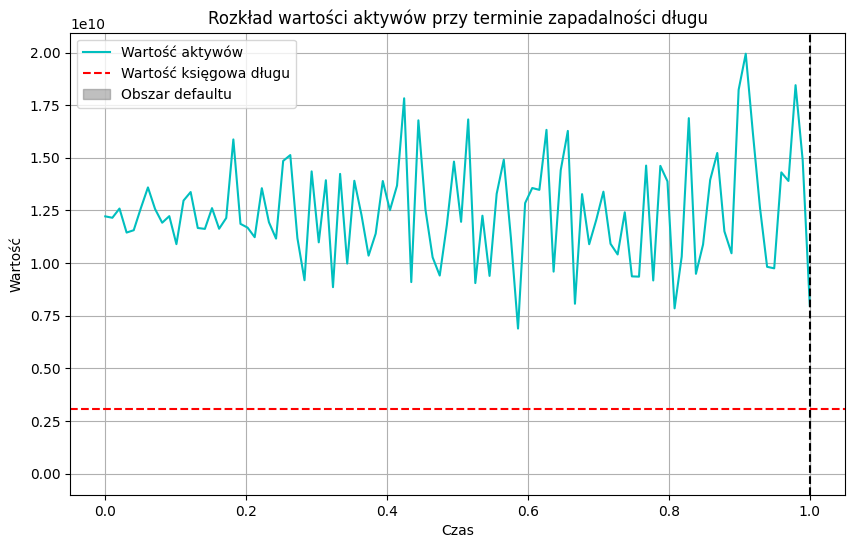

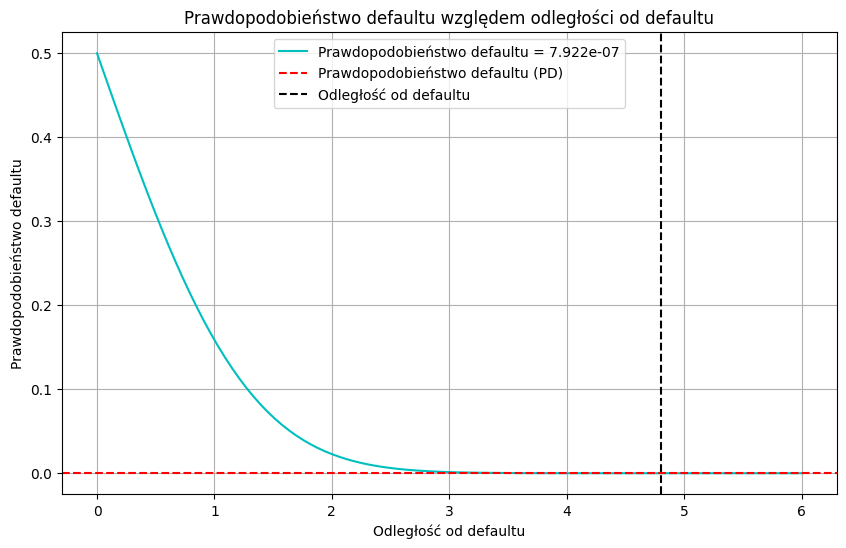

In [40]:
# Wizualizacja wyników

# Wykres wartości aktywów w czasie
time = np.linspace(0, okres_analizy, 100)
value_of_assets = V_bc * np.exp((stopa_wolna_od_ryzyka - 0.5 * sigma_V_bc**2) * time + sigma_V_bc * np.sqrt(time) * np.random.normal(0, 1, 100))

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(time, value_of_assets, label='Wartość aktywów', color = 'c')
plt.axhline(y=wartosc_ksiegowa_dlugu, color='r', linestyle='--', label='Wartość księgowa długu')
plt.axvline(x=okres_analizy, color='k', linestyle='--')
plt.fill_between(time, 0, wartosc_ksiegowa_dlugu, where=(time >= okres_analizy), color='grey', alpha=0.5, label='Obszar defaultu')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.title('Rozkład wartości aktywów przy terminie zapadalności długu')
plt.legend()
plt.savefig('Rozkład wartości aktywów przy terminie zapadalności długu')
plt.show()

# Wykres prawdopodobieństwa defaultu względem odległości od defaultu
default_distance = np.linspace(0, 6, 100)
probability_of_default = norm.cdf(-default_distance)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(default_distance, probability_of_default, label=f'Prawdopodobieństwo defaultu = {PD_bc:.4g}', color = 'c')
plt.axhline(y=PD_bc, color='r', linestyle='--', label='Prawdopodobieństwo defaultu (PD)')
plt.axvline(x=(np.log(V_bc/wartosc_ksiegowa_dlugu) + (stopa_wolna_od_ryzyka - 0.5 * sigma_V_bc**2) * okres_analizy) / (sigma_V_bc * np.sqrt(okres_analizy)), color='k', linestyle='--', label='Odległość od defaultu')
plt.xlabel('Odległość od defaultu')
plt.ylabel('Prawdopodobieństwo defaultu')
plt.title('Prawdopodobieństwo defaultu względem odległości od defaultu')
plt.legend()
plt.savefig('Prawdopodobieństwo defaultu względem odległości od defaultu')
plt.show()
